In [2]:
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
import tools
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from math import pi
from pixell import enmap, curvedsky

In [3]:
ellmax=7000
ells = np.arange(0, ellmax+1, 1)
ellmin = 200

# write WebSky alm

In [4]:
if 0:
    ksz_lt_alm = hp.map2alm(hp.read_map('./maps/websky/ksz.fits'), lmax=ellmax)
    hp.write_alm('./maps/websky/ksz_lt_alm.fits', ksz_lt_alm)

    ksz_ri_alm = hp.map2alm(hp.read_map('./maps/websky/ksz_patchy.fits'),lmax=ellmax)
    hp.write_alm('./maps/websky/ksz_ri_alm.fits', ksz_ri_alm)
    
    kap_alm = hp.map2alm(hp.read_map('./maps/websky/kap.fits'), lmax=ellmax)
    hp.write_alm('./maps/websky/kap_alm.fits', kap_alm)

# write Sehgal alm

In [5]:
if 0:
    ksz_lt_alm = hp.map2alm(hp.read_map('./maps/sehgal/148_ksz_healpix_nopell_Nside4096_DeltaT_uK.fits'), lmax=ellmax)
    hp.write_alm('./maps/sehgal/ksz_lt_alm.fits', ksz_lt_alm)

    kap_alm = hp.map2alm(hp.read_map('./maps/sehgal/healpix_4096_KappaeffLSStoCMBfullsky.fits'), lmax=ellmax)
    hp.write_alm('./maps/sehgal/kap_alm.fits', kap_alm)

# check WebSky and Sehgal kSZ auto_cl and cross_cl

In [6]:
# websky
ksz_alm_lt = hp.read_alm('./maps/websky/ksz_lt_alm.fits')
ksz_alm_ri = hp.read_alm('./maps/websky/ksz_ri_alm.fits')
ksz_cl_lt = hp.alm2cl(ksz_alm_lt, lmax=ellmax)
ksz_cl_ri = hp.alm2cl(ksz_alm_ri, lmax=ellmax)

# sehgal
ksz_alm_lt_s = hp.read_alm('./maps/sehgal/ksz_lt_alm.fits')
ksz_cl_lt_s = hp.alm2cl(ksz_alm_lt_s, lmax=ellmax)

In [41]:
lensed_alm = hp.read_alm('../new_reion-lens/maps/websky/alms/lensed_cmb_alms_7000.fits')
lensed_cl = hp.alm2cl(lensed_alm)

Text(0.5, 0, '$\\ell$')

Text(0, 0.5, '$\\ell(\\ell+1)/(2\\pi)C^{TT}_{\\ell} [\\mu K^2]$')

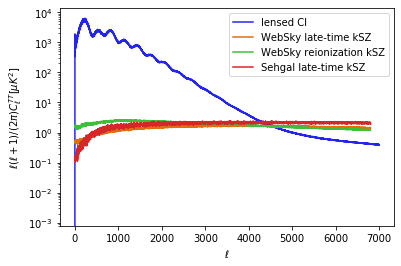

In [51]:
factor = ells*(ells+1)/(2*pi)
plt.plot((factor*lensed_cl), label='lensed Cl')
plt.plot((factor*ksz_cl_lt)[ellmin:], label='WebSky late-time kSZ')
plt.plot((factor*ksz_cl_ri)[ellmin:], label='WebSky reionization kSZ')
plt.plot((factor*ksz_cl_lt_s)[ellmin:], label='Sehgal late-time kSZ')

plt.legend()
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C^{TT}_{\ell} [\mu K^2]$')
if 0:
    plt.savefig('./output/draft_plot/ps_raw.pdf')
    plt.savefig('./output/draft_plot/ps_raw.png')

# check WebSky and Sehgal kSZ cross_cl

In [9]:
if 0:
    ksz_lt_alm2 = hp.map2alm(hp.read_map('./maps/websky/ksz.fits')**2, lmax=ellmax)
    hp.write_alm('./maps/websky/ksz_lt_alm2.fits', ksz_lt_alm2)
    
    ksz_lt_alm2_s = hp.map2alm(hp.read_map('./maps/sehgal/148_ksz_healpix_nopell_Nside4096_DeltaT_uK.fits')**2, lmax=ellmax)
    hp.write_alm('./maps/sehgal/ksz_lt_alm2.fits', ksz_lt_alm2_s)

In [10]:
# websky cross ps
ksz_lt_alm2 = hp.read_alm('./maps/websky/ksz_lt_alm2.fits')
kap_alm = hp.read_alm('./maps/websky/kap_alm.fits')
cross_ps = hp.alm2cl(ksz_lt_alm2, kap_alm)

# sehgal cross ps
ksz_lt_alm2_s = hp.read_alm('./maps/sehgal/ksz_lt_alm2.fits')
kap_alm_s = hp.read_alm('./maps/sehgal/kap_alm.fits')
cross_ps_s = hp.alm2cl(ksz_lt_alm2_s, kap_alm_s)

Text(0.5, 0, '$\\ell$')

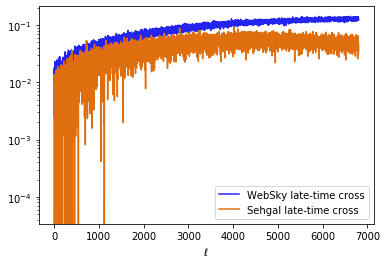

In [48]:
plt.plot((factor*cross_ps)[ellmin:], label='WebSky late-time cross')
plt.plot((factor*cross_ps_s)[ellmin:], label='Sehgal late-time cross')
plt.legend()
plt.yscale('log')
plt.xlabel('$\ell$')
if 0:
    plt.savefig('./output/draft_plot/cross_ps_raw.pdf')
    plt.savefig('./output/draft_plot/cross_ps_raw.png')    

# bin the curves

In [12]:
class bin1D(object):
    def __init__(self, ls, bin_edges):
        self.centers = (bin_edges[1:]+bin_edges[:-1])/2.
        self.digitized = np.digitize(ls, bin_edges,right=True)
        self.bin_edges = bin_edges
    def bin(self,data1d,weights=None):
        if weights is None:
            res = np.bincount(self.digitized,(data1d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
        else:
            res = np.bincount(self.digitized,(data1d*weights).reshape(-1))[1:-1]/np.bincount(self.digitized,weights.reshape(-1))[1:-1]
        return self.centers,res

In [13]:
delta_l = 50
bin_edges = np.arange(0, ellmax, delta_l)
binner = bin1D(ells, bin_edges)

In [14]:
ells_bin, ksz_cl_lt_bin = binner.bin(ksz_cl_lt)
ells_bin, ksz_cl_ri_bin = binner.bin(ksz_cl_ri)
ells_bin, ksz_cl_lt_s_bin = binner.bin(ksz_cl_lt_s)
ells_bin, cross_ps_bin = binner.bin(cross_ps)
ells_bin, cross_ps_s_bin = binner.bin(cross_ps_s)
ells_bin, lensed_cl_bin = binner.bin(lensed_cl)
ells_bin_min = 10

Text(0.5, 0, '$\\ell$')

Text(0, 0.5, '$\\ell(\\ell+1)/(2\\pi)C^{TT}_{\\ell} [\\mu K^2]$')

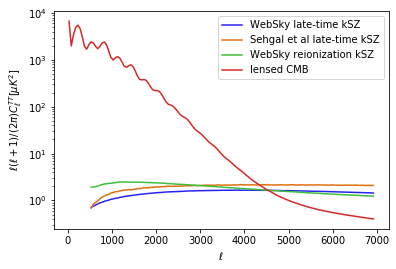

In [53]:
factor_bin = ells_bin*(ells_bin+1)/(2*pi)
plt.plot(ells_bin[ells_bin_min:], (factor_bin*ksz_cl_lt_bin)[ells_bin_min:], label='WebSky late-time kSZ')
plt.plot(ells_bin[ells_bin_min:], (factor_bin*ksz_cl_lt_s_bin)[ells_bin_min:], label='Sehgal et al late-time kSZ')
plt.plot(ells_bin[ells_bin_min:], (factor_bin*ksz_cl_ri_bin)[ells_bin_min:], label='WebSky reionization kSZ')
plt.plot(ells_bin, factor_bin*lensed_cl_bin, label='lensed CMB')
plt.legend()
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C^{TT}_{\ell} [\mu K^2]$')
if 0:
    plt.savefig('./output/draft_plot/ps.pdf')
    plt.savefig('./output/draft_plot/ps.png')

Text(0.5, 0, '$\\ell$')

Text(0, 0.5, '$<(T^{\\mathrm{kSZ}})^2 \\kappa> [\\mu K^2]$')

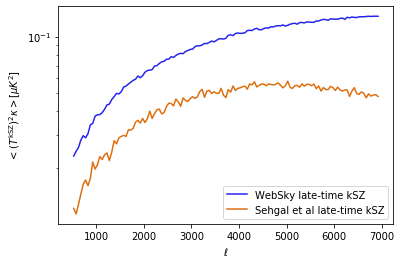

In [54]:
plt.plot(ells_bin[ells_bin_min:], (factor_bin*cross_ps_bin)[ells_bin_min:], label='WebSky late-time kSZ')
plt.plot(ells_bin[ells_bin_min:], (factor_bin*cross_ps_s_bin)[ells_bin_min:], label='Sehgal et al late-time kSZ')
plt.legend()
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel(r'$<(T^{\mathrm{kSZ}})^2 \kappa> [\mu K^2]$')
if 1:
    plt.savefig('./output/draft_plot/cross_ps.pdf')
    plt.savefig('./output/draft_plot/cross_ps.png')    